In [12]:
import numpy as np
import sympy as sp
from scipy.optimize import fsolve, brentq
import matplotlib.pyplot as plt
import os

# Ensure the 'data' and 'figs' directories exist
os.makedirs('data', exist_ok=True)
os.makedirs('figs', exist_ok=True)

In [13]:
# ------------------------------------------------------------------------
# Helper Functions
# ------------------------------------------------------------------------

def coleman_homophily_index(c, i, frac_red):
    """
    Compute the Coleman homophily index for a clique of size c with i red nodes.
    """
    exp_in = frac_red**2 + (1 - frac_red)**2
    in_group = (i*(i-1) + (c - i)*(c - i - 1)) / (c*(c-1))
    return (in_group - exp_in) / (1 - exp_in)

def compute_F_maxent(c, h, frac_red):
    """
    Compute the maximum entropy distribution F for a clique of size c,
    given homophily h and fraction of red nodes frac_red.
    """
    i_values = np.arange(c + 1)
    h_i = np.array([coleman_homophily_index(c, i, frac_red) for i in i_values])

    def equations(lambdas):
        lambda1, lambda2 = lambdas
        exp_terms = np.exp(lambda1 * i_values + lambda2 * h_i)
        Z = np.sum(exp_terms)
        F = exp_terms / Z
        f1 = np.sum(i_values * F) - c * frac_red
        f2 = np.sum(h_i * F) - h
        return [f1, f2]

    # Initial guess
    initial_guess = [0.0, 0.0]
    try:
        sol = fsolve(equations, initial_guess)
        lambda1, lambda2 = sol
        exp_terms = np.exp(lambda1 * i_values + lambda2 * h_i)
        Z = np.sum(exp_terms)
        F = exp_terms / Z
        return F
    except Exception as e:
        print(f"Failed to compute F for c={c}, h={h}, frac_red={frac_red}: {e}")
        return None

def generate_B_matrix(F1, F2, p_rr, p_rb, p_bb, N_r, N_b, M1, M2, c1, c2):
    """
    Generate the B matrix for the percolation process.
    """
    # Number of red and blue nodes
    total_types = 2  # Red and Blue

    # Initialize B matrix
    B = np.zeros((total_types, total_types))

    # Contribution from cliques of size c1
    B += compute_B_block(F1, p_rr, p_rb, p_bb, N_r, N_b, M1, c1)

    # Contribution from cliques of size c2
    B += compute_B_block(F2, p_rr, p_rb, p_bb, N_r, N_b, M2, c2)

    return B

def compute_B_block(F, p_rr, p_rb, p_bb, N_r, N_b, M, c):
    """
    Compute the B matrix block for a given clique size.
    """
    # Initialize block
    B_block = np.zeros((2, 2))

    # Possible number of red nodes in the clique
    i_values = np.arange(c + 1)

    for i, F_i in enumerate(F):
        if F_i == 0:
            continue

        i_red = i
        i_blue = c - i

        # Probabilities
        prob = F_i * M

        # Expected number of edges
        E_rr = i_red * (i_red - 1) / 2
        E_rb = i_red * i_blue
        E_bb = i_blue * (i_blue - 1) / 2

        # Expected degrees after percolation
        k_rr = 0
        k_rb = 0
        if i_red > 0:
            k_rr = (2 * E_rr * p_rr) / i_red
            k_rb = (E_rb * p_rb) / i_red

        k_bb = 0
        k_br = 0
        if i_blue > 0:
            k_bb = (2 * E_bb * p_bb) / i_blue
            k_br = (E_rb * p_rb) / i_blue

        # From red nodes
        if i_red > 0:
            B_block[0, 0] += (prob * i_red / N_r) * k_rr
            B_block[0, 1] += (prob * i_red / N_r) * k_rb

        # From blue nodes
        if i_blue > 0:
            B_block[1, 0] += (prob * i_blue / N_b) * k_br
            B_block[1, 1] += (prob * i_blue / N_b) * k_bb

    return B_block

/tmp/ipykernel_2623407/1645205272.py:33: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  sol = fsolve(equations, initial_guess)


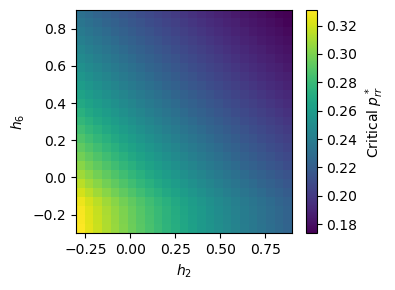

In [26]:
# ------------------------------------------------------------------------
# Main Execution
# ------------------------------------------------------------------------

if __name__ == "__main__":
    # Parameters
    c1 = 6
    c2 = 2
    N = 500000
    frac_red = 0.6
    N_r = int(frac_red * N)
    N_b = N - N_r
    ave_degree = 6

    # Calculate alpha
    def alpha_star(c1, c2):
        numerator = c2 * (c2 - 1)
        denominator = c2 * (c2 - 1) + c1 * (c1 - 1)
        return numerator / denominator

    alpha = alpha_star(c1, c2)

    # Total number of cliques
    M_total = ave_degree * N / (
        (1 - alpha) * c2 * (c2 - 1) + alpha * c1 * (c1 - 1)
    )
    M1 = int(alpha * M_total)
    M2 = int((1 - alpha) * M_total)

    # Percolation probabilities
    p_bb = 0.0
    p_rb = 0.0

    # Homophily ranges
    h1_values = np.linspace(-0.3, 0.9, 25)
    h2_values = np.linspace(-0.3, 0.9, 25)

    # Initialize matrix to store critical probabilities
    p_rr_matrix = np.zeros((len(h1_values), len(h2_values)))

    # Loop over homophily values
    for i, h1 in enumerate(h1_values):
        for j, h2 in enumerate(h2_values):
            # Compute F1 and F2
            F1 = compute_F_maxent(c1, h1, frac_red)
            F2 = compute_F_maxent(c2, h2, frac_red)

            if F1 is None or F2 is None:
                p_rr_matrix[i, j] = np.nan
                continue

            # Function to find root
            def eigenvalue_function(p_rr):
                B = generate_B_matrix(F1, F2, p_rr, p_rb, p_bb, N_r, N_b, M1, M2, c1, c2)
                eigenvalues = np.linalg.eigvals(B)
                max_eigenvalue = max(np.abs(eigenvalues))
                return max_eigenvalue - 1

            try:
                # Check if eigenvalue_function changes sign between 0 and 1
                f0 = eigenvalue_function(0)
                f1 = eigenvalue_function(1)

                if f0 * f1 > 0:
                    # No root in [0,1]
                    p_rr_matrix[i, j] = np.nan
                else:
                    # Find critical p_rr
                    p_rr_star = brentq(eigenvalue_function, 0, 1)
                    p_rr_matrix[i, j] = p_rr_star
                   # print(f"h1={h1:.2f}, h2={h2:.2f}, p_rr*={p_rr_star:.4f}")
            except Exception as e:
                p_rr_matrix[i, j] = np.nan
                #print(f"Failed at h1={h1}, h2={h2}: {e}")

    # Save the data
    np.save('data/critical_p_rr_'+str(p_bb)+'_'+str(p_rb)+'_.npy', p_rr_matrix)

    # Plotting
    plt.figure(figsize=(4, 3))
    plt.imshow(p_rr_matrix, origin='lower', extent=[h2_values[0], h2_values[-1], h1_values[0], h1_values[-1]],
               aspect='auto', cmap='viridis')
    plt.colorbar(label='Critical $p_{rr}^*$')
    plt.xlabel('$h_2$')
    plt.ylabel('$h_6$')
    #plt.title('Critical Percolation Probability $\pi_{rr}^*$')
    plt.tight_layout()

    # Save the figure
    plt.savefig('figs/critical_p_rr_'+str(p_bb)+'_'+str(p_rb)+'_.pdf')
    plt.show()

/tmp/ipykernel_2623407/1645205272.py:33: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  sol = fsolve(equations, initial_guess)


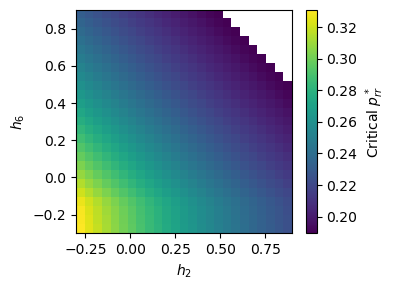

In [25]:
# ------------------------------------------------------------------------
# Main Execution
# ------------------------------------------------------------------------

if __name__ == "__main__":
    # Parameters
    c1 = 6
    c2 = 2
    N = 500000
    frac_red = 0.6
    N_r = int(frac_red * N)
    N_b = N - N_r
    ave_degree = 6

    # Calculate alpha
    def alpha_star(c1, c2):
        numerator = c2 * (c2 - 1)
        denominator = c2 * (c2 - 1) + c1 * (c1 - 1)
        return numerator / denominator

    alpha = alpha_star(c1, c2)

    # Total number of cliques
    M_total = ave_degree * N / (
        (1 - alpha) * c2 * (c2 - 1) + alpha * c1 * (c1 - 1)
    )
    M1 = int(alpha * M_total)
    M2 = int((1 - alpha) * M_total)

    # Percolation probabilities
    p_bb = 0.2
    p_rb = 0.0

    # Homophily ranges
    h1_values = np.linspace(-0.3, 0.9, 25)
    h2_values = np.linspace(-0.3, 0.9, 25)

    # Initialize matrix to store critical probabilities
    p_rr_matrix = np.zeros((len(h1_values), len(h2_values)))

    # Loop over homophily values
    for i, h1 in enumerate(h1_values):
        for j, h2 in enumerate(h2_values):
            # Compute F1 and F2
            F1 = compute_F_maxent(c1, h1, frac_red)
            F2 = compute_F_maxent(c2, h2, frac_red)

            if F1 is None or F2 is None:
                p_rr_matrix[i, j] = np.nan
                continue

            # Function to find root
            def eigenvalue_function(p_rr):
                B = generate_B_matrix(F1, F2, p_rr, p_rb, p_bb, N_r, N_b, M1, M2, c1, c2)
                eigenvalues = np.linalg.eigvals(B)
                max_eigenvalue = max(np.abs(eigenvalues))
                return max_eigenvalue - 1

            try:
                # Check if eigenvalue_function changes sign between 0 and 1
                f0 = eigenvalue_function(0)
                f1 = eigenvalue_function(1)

                if f0 * f1 > 0:
                    # No root in [0,1]
                    p_rr_matrix[i, j] = np.nan
                else:
                    # Find critical p_rr
                    p_rr_star = brentq(eigenvalue_function, 0, 1)
                    p_rr_matrix[i, j] = p_rr_star
                   # print(f"h1={h1:.2f}, h2={h2:.2f}, p_rr*={p_rr_star:.4f}")
            except Exception as e:
                p_rr_matrix[i, j] = np.nan
                #print(f"Failed at h1={h1}, h2={h2}: {e}")

    # Save the data
    np.save('data/critical_p_rr_'+str(p_bb)+'_'+str(p_rb)+'_.npy', p_rr_matrix)

    # Plotting
    plt.figure(figsize=(4, 3))
    plt.imshow(p_rr_matrix, origin='lower', extent=[h2_values[0], h2_values[-1], h1_values[0], h1_values[-1]],
               aspect='auto', cmap='viridis')
    plt.colorbar(label='Critical $p_{rr}^*$')
    plt.xlabel('$h_2$')
    plt.ylabel('$h_6$')
    #plt.title('Critical Percolation Probability $\pi_{rr}^*$')
    plt.tight_layout()

    # Save the figure
    plt.savefig('figs/critical_p_rr_'+str(p_bb)+'_'+str(p_rb)+'_.pdf')
    plt.show()

/tmp/ipykernel_2623407/1645205272.py:33: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  sol = fsolve(equations, initial_guess)


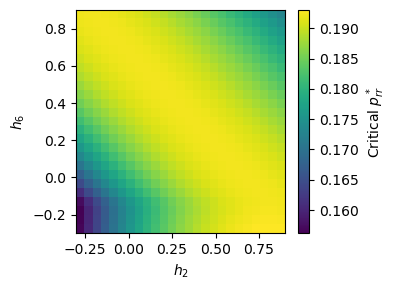

In [22]:
# ------------------------------------------------------------------------
# Main Execution
# ------------------------------------------------------------------------

if __name__ == "__main__":
    # Parameters
    c1 = 6
    c2 = 2
    N = 500000
    frac_red = 0.6
    N_r = int(frac_red * N)
    N_b = N - N_r
    ave_degree = 6

    # Calculate alpha
    def alpha_star(c1, c2):
        numerator = c2 * (c2 - 1)
        denominator = c2 * (c2 - 1) + c1 * (c1 - 1)
        return numerator / denominator

    alpha = alpha_star(c1, c2)

    # Total number of cliques
    M_total = ave_degree * N / (
        (1 - alpha) * c2 * (c2 - 1) + alpha * c1 * (c1 - 1)
    )
    M1 = int(alpha * M_total)
    M2 = int((1 - alpha) * M_total)

    # Percolation probabilities
    p_bb = 0.0
    p_rb = 0.2

    # Homophily ranges
    h1_values = np.linspace(-0.3, 0.9, 25)
    h2_values = np.linspace(-0.3, 0.9, 25)

    # Initialize matrix to store critical probabilities
    p_rr_matrix = np.zeros((len(h1_values), len(h2_values)))

    # Loop over homophily values
    for i, h1 in enumerate(h1_values):
        for j, h2 in enumerate(h2_values):
            # Compute F1 and F2
            F1 = compute_F_maxent(c1, h1, frac_red)
            F2 = compute_F_maxent(c2, h2, frac_red)

            if F1 is None or F2 is None:
                p_rr_matrix[i, j] = np.nan
                continue

            # Function to find root
            def eigenvalue_function(p_rr):
                B = generate_B_matrix(F1, F2, p_rr, p_rb, p_bb, N_r, N_b, M1, M2, c1, c2)
                eigenvalues = np.linalg.eigvals(B)
                max_eigenvalue = max(np.abs(eigenvalues))
                return max_eigenvalue - 1

            try:
                # Check if eigenvalue_function changes sign between 0 and 1
                f0 = eigenvalue_function(0)
                f1 = eigenvalue_function(1)

                if f0 * f1 > 0:
                    # No root in [0,1]
                    p_rr_matrix[i, j] = np.nan
                else:
                    # Find critical p_rr
                    p_rr_star = brentq(eigenvalue_function, 0, 1)
                    p_rr_matrix[i, j] = p_rr_star
                   # print(f"h1={h1:.2f}, h2={h2:.2f}, p_rr*={p_rr_star:.4f}")
            except Exception as e:
                p_rr_matrix[i, j] = np.nan
                #print(f"Failed at h1={h1}, h2={h2}: {e}")

    # Save the data
    np.save('data/critical_p_rr_'+str(p_bb)+'_'+str(p_rb)+'_.npy', p_rr_matrix)

    # Plotting
    plt.figure(figsize=(4, 3))
    plt.imshow(p_rr_matrix, origin='lower', extent=[h2_values[0], h2_values[-1], h1_values[0], h1_values[-1]],
               aspect='auto', cmap='viridis')
    plt.colorbar(label='Critical $p_{rr}^*$')
    plt.xlabel('$h_2$')
    plt.ylabel('$h_6$')
    #plt.title('Critical Percolation Probability $\pi_{rr}^*$')
    plt.tight_layout()

    # Save the figure
    plt.savefig('figs/critical_p_rr_'+str(p_bb)+'_'+str(p_rb)+'_.pdf')
    plt.show()

/tmp/ipykernel_2623407/1645205272.py:33: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  sol = fsolve(equations, initial_guess)


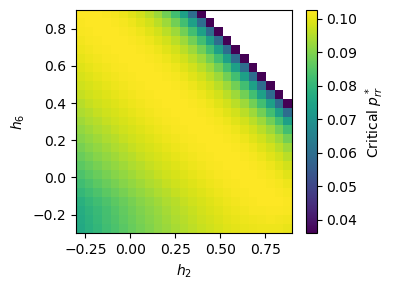

In [23]:
# ------------------------------------------------------------------------
# Main Execution
# ------------------------------------------------------------------------

if __name__ == "__main__":
    # Parameters
    c1 = 6
    c2 = 2
    N = 500000
    frac_red = 0.6
    N_r = int(frac_red * N)
    N_b = N - N_r
    ave_degree = 6

    # Calculate alpha
    def alpha_star(c1, c2):
        numerator = c2 * (c2 - 1)
        denominator = c2 * (c2 - 1) + c1 * (c1 - 1)
        return numerator / denominator

    alpha = alpha_star(c1, c2)

    # Total number of cliques
    M_total = ave_degree * N / (
        (1 - alpha) * c2 * (c2 - 1) + alpha * c1 * (c1 - 1)
    )
    M1 = int(alpha * M_total)
    M2 = int((1 - alpha) * M_total)

    # Percolation probabilities
    p_bb = 0.2
    p_rb = 0.2

    # Homophily ranges
    h1_values = np.linspace(-0.3, 0.9, 25)
    h2_values = np.linspace(-0.3, 0.9, 25)

    # Initialize matrix to store critical probabilities
    p_rr_matrix = np.zeros((len(h1_values), len(h2_values)))

    # Loop over homophily values
    for i, h1 in enumerate(h1_values):
        for j, h2 in enumerate(h2_values):
            # Compute F1 and F2
            F1 = compute_F_maxent(c1, h1, frac_red)
            F2 = compute_F_maxent(c2, h2, frac_red)

            if F1 is None or F2 is None:
                p_rr_matrix[i, j] = np.nan
                continue

            # Function to find root
            def eigenvalue_function(p_rr):
                B = generate_B_matrix(F1, F2, p_rr, p_rb, p_bb, N_r, N_b, M1, M2, c1, c2)
                eigenvalues = np.linalg.eigvals(B)
                max_eigenvalue = max(np.abs(eigenvalues))
                return max_eigenvalue - 1

            try:
                # Check if eigenvalue_function changes sign between 0 and 1
                f0 = eigenvalue_function(0)
                f1 = eigenvalue_function(1)

                if f0 * f1 > 0:
                    # No root in [0,1]
                    p_rr_matrix[i, j] = np.nan
                else:
                    # Find critical p_rr
                    p_rr_star = brentq(eigenvalue_function, 0, 1)
                    p_rr_matrix[i, j] = p_rr_star
                   # print(f"h1={h1:.2f}, h2={h2:.2f}, p_rr*={p_rr_star:.4f}")
            except Exception as e:
                p_rr_matrix[i, j] = np.nan
                #print(f"Failed at h1={h1}, h2={h2}: {e}")

    # Save the data
    np.save('data/critical_p_rr_'+str(p_bb)+'_'+str(p_rb)+'_.npy', p_rr_matrix)

    # Plotting
    plt.figure(figsize=(4, 3))
    plt.imshow(p_rr_matrix, origin='lower', extent=[h2_values[0], h2_values[-1], h1_values[0], h1_values[-1]],
               aspect='auto', cmap='viridis')
    plt.colorbar(label='Critical $p_{rr}^*$')
    plt.xlabel('$h_2$')
    plt.ylabel('$h_6$')
    #plt.title('Critical Percolation Probability $\pi_{rr}^*$')
    plt.tight_layout()

    # Save the figure
    plt.savefig('figs/critical_p_rr_'+str(p_bb)+'_'+str(p_rb)+'_.pdf')
    plt.show()

/tmp/ipykernel_2623407/1645205272.py:33: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  sol = fsolve(equations, initial_guess)


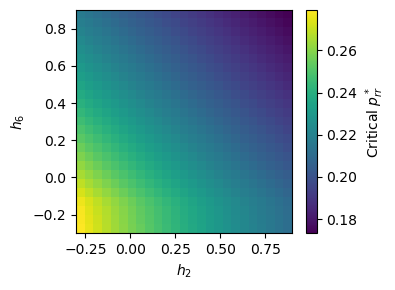

In [24]:
# ------------------------------------------------------------------------
# Main Execution
# ------------------------------------------------------------------------

if __name__ == "__main__":
    # Parameters
    c1 = 6
    c2 = 2
    N = 500000
    frac_red = 0.6
    N_r = int(frac_red * N)
    N_b = N - N_r
    ave_degree = 6

    # Calculate alpha
    def alpha_star(c1, c2):
        numerator = c2 * (c2 - 1)
        denominator = c2 * (c2 - 1) + c1 * (c1 - 1)
        return numerator / denominator

    alpha = alpha_star(c1, c2)

    # Total number of cliques
    M_total = ave_degree * N / (
        (1 - alpha) * c2 * (c2 - 1) + alpha * c1 * (c1 - 1)
    )
    M1 = int(alpha * M_total)
    M2 = int((1 - alpha) * M_total)

    # Percolation probabilities
    p_bb = 0.1
    p_rb = 0.1

    # Homophily ranges
    h1_values = np.linspace(-0.3, 0.9, 25)
    h2_values = np.linspace(-0.3, 0.9, 25)

    # Initialize matrix to store critical probabilities
    p_rr_matrix = np.zeros((len(h1_values), len(h2_values)))

    # Loop over homophily values
    for i, h1 in enumerate(h1_values):
        for j, h2 in enumerate(h2_values):
            # Compute F1 and F2
            F1 = compute_F_maxent(c1, h1, frac_red)
            F2 = compute_F_maxent(c2, h2, frac_red)

            if F1 is None or F2 is None:
                p_rr_matrix[i, j] = np.nan
                continue

            # Function to find root
            def eigenvalue_function(p_rr):
                B = generate_B_matrix(F1, F2, p_rr, p_rb, p_bb, N_r, N_b, M1, M2, c1, c2)
                eigenvalues = np.linalg.eigvals(B)
                max_eigenvalue = max(np.abs(eigenvalues))
                return max_eigenvalue - 1

            try:
                # Check if eigenvalue_function changes sign between 0 and 1
                f0 = eigenvalue_function(0)
                f1 = eigenvalue_function(1)

                if f0 * f1 > 0:
                    # No root in [0,1]
                    p_rr_matrix[i, j] = np.nan
                else:
                    # Find critical p_rr
                    p_rr_star = brentq(eigenvalue_function, 0, 1)
                    p_rr_matrix[i, j] = p_rr_star
                   # print(f"h1={h1:.2f}, h2={h2:.2f}, p_rr*={p_rr_star:.4f}")
            except Exception as e:
                p_rr_matrix[i, j] = np.nan
                #print(f"Failed at h1={h1}, h2={h2}: {e}")

    # Save the data
    np.save('data/critical_p_rr_'+str(p_bb)+'_'+str(p_rb)+'_.npy', p_rr_matrix)

    # Plotting
    plt.figure(figsize=(4, 3))
    plt.imshow(p_rr_matrix, origin='lower', extent=[h2_values[0], h2_values[-1], h1_values[0], h1_values[-1]],
               aspect='auto', cmap='viridis')
    plt.colorbar(label='Critical $p_{rr}^*$')
    plt.xlabel('$h_2$')
    plt.ylabel('$h_6$')
    #plt.title('Critical Percolation Probability $\pi_{rr}^*$')
    plt.tight_layout()

    # Save the figure
    plt.savefig('figs/critical_p_rr_'+str(p_bb)+'_'+str(p_rb)+'_.pdf')
    plt.show()

/tmp/ipykernel_2623407/1645205272.py:33: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  sol = fsolve(equations, initial_guess)


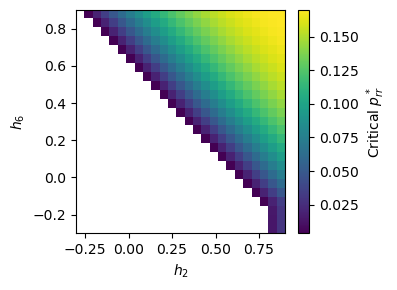

In [27]:
# ------------------------------------------------------------------------
# Main Execution
# ------------------------------------------------------------------------

if __name__ == "__main__":
    # Parameters
    c1 = 6
    c2 = 2
    N = 500000
    frac_red = 0.6
    N_r = int(frac_red * N)
    N_b = N - N_r
    ave_degree = 6

    # Calculate alpha
    def alpha_star(c1, c2):
        numerator = c2 * (c2 - 1)
        denominator = c2 * (c2 - 1) + c1 * (c1 - 1)
        return numerator / denominator

    alpha = alpha_star(c1, c2)

    # Total number of cliques
    M_total = ave_degree * N / (
        (1 - alpha) * c2 * (c2 - 1) + alpha * c1 * (c1 - 1)
    )
    M1 = int(alpha * M_total)
    M2 = int((1 - alpha) * M_total)

    # Percolation probabilities
    p_bb = 0.0
    p_rb = 0.5

    # Homophily ranges
    h1_values = np.linspace(-0.3, 0.9, 25)
    h2_values = np.linspace(-0.3, 0.9, 25)

    # Initialize matrix to store critical probabilities
    p_rr_matrix = np.zeros((len(h1_values), len(h2_values)))

    # Loop over homophily values
    for i, h1 in enumerate(h1_values):
        for j, h2 in enumerate(h2_values):
            # Compute F1 and F2
            F1 = compute_F_maxent(c1, h1, frac_red)
            F2 = compute_F_maxent(c2, h2, frac_red)

            if F1 is None or F2 is None:
                p_rr_matrix[i, j] = np.nan
                continue

            # Function to find root
            def eigenvalue_function(p_rr):
                B = generate_B_matrix(F1, F2, p_rr, p_rb, p_bb, N_r, N_b, M1, M2, c1, c2)
                eigenvalues = np.linalg.eigvals(B)
                max_eigenvalue = max(np.abs(eigenvalues))
                return max_eigenvalue - 1

            try:
                # Check if eigenvalue_function changes sign between 0 and 1
                f0 = eigenvalue_function(0)
                f1 = eigenvalue_function(1)

                if f0 * f1 > 0:
                    # No root in [0,1]
                    p_rr_matrix[i, j] = np.nan
                else:
                    # Find critical p_rr
                    p_rr_star = brentq(eigenvalue_function, 0, 1)
                    p_rr_matrix[i, j] = p_rr_star
                   # print(f"h1={h1:.2f}, h2={h2:.2f}, p_rr*={p_rr_star:.4f}")
            except Exception as e:
                p_rr_matrix[i, j] = np.nan
                #print(f"Failed at h1={h1}, h2={h2}: {e}")

    # Save the data
    np.save('data/critical_p_rr_'+str(p_bb)+'_'+str(p_rb)+'_.npy', p_rr_matrix)

    # Plotting
    plt.figure(figsize=(4, 3))
    plt.imshow(p_rr_matrix, origin='lower', extent=[h2_values[0], h2_values[-1], h1_values[0], h1_values[-1]],
               aspect='auto', cmap='viridis')
    plt.colorbar(label='Critical $p_{rr}^*$')
    plt.xlabel('$h_2$')
    plt.ylabel('$h_6$')
    #plt.title('Critical Percolation Probability $\pi_{rr}^*$')
    plt.tight_layout()

    # Save the figure
    plt.savefig('figs/critical_p_rr_'+str(p_bb)+'_'+str(p_rb)+'_.pdf')
    plt.show()

/tmp/ipykernel_2623407/1645205272.py:33: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  sol = fsolve(equations, initial_guess)


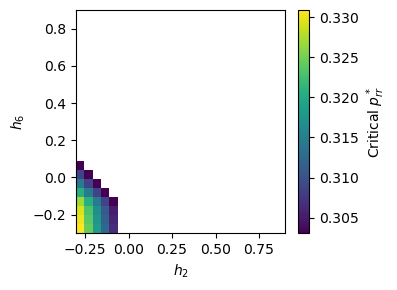

In [28]:
# ------------------------------------------------------------------------
# Main Execution
# ------------------------------------------------------------------------

if __name__ == "__main__":
    # Parameters
    c1 = 6
    c2 = 2
    N = 500000
    frac_red = 0.6
    N_r = int(frac_red * N)
    N_b = N - N_r
    ave_degree = 6

    # Calculate alpha
    def alpha_star(c1, c2):
        numerator = c2 * (c2 - 1)
        denominator = c2 * (c2 - 1) + c1 * (c1 - 1)
        return numerator / denominator

    alpha = alpha_star(c1, c2)

    # Total number of cliques
    M_total = ave_degree * N / (
        (1 - alpha) * c2 * (c2 - 1) + alpha * c1 * (c1 - 1)
    )
    M1 = int(alpha * M_total)
    M2 = int((1 - alpha) * M_total)

    # Percolation probabilities
    p_bb = 0.5
    p_rb = 0.0

    # Homophily ranges
    h1_values = np.linspace(-0.3, 0.9, 25)
    h2_values = np.linspace(-0.3, 0.9, 25)

    # Initialize matrix to store critical probabilities
    p_rr_matrix = np.zeros((len(h1_values), len(h2_values)))

    # Loop over homophily values
    for i, h1 in enumerate(h1_values):
        for j, h2 in enumerate(h2_values):
            # Compute F1 and F2
            F1 = compute_F_maxent(c1, h1, frac_red)
            F2 = compute_F_maxent(c2, h2, frac_red)

            if F1 is None or F2 is None:
                p_rr_matrix[i, j] = np.nan
                continue

            # Function to find root
            def eigenvalue_function(p_rr):
                B = generate_B_matrix(F1, F2, p_rr, p_rb, p_bb, N_r, N_b, M1, M2, c1, c2)
                eigenvalues = np.linalg.eigvals(B)
                max_eigenvalue = max(np.abs(eigenvalues))
                return max_eigenvalue - 1

            try:
                # Check if eigenvalue_function changes sign between 0 and 1
                f0 = eigenvalue_function(0)
                f1 = eigenvalue_function(1)

                if f0 * f1 > 0:
                    # No root in [0,1]
                    p_rr_matrix[i, j] = np.nan
                else:
                    # Find critical p_rr
                    p_rr_star = brentq(eigenvalue_function, 0, 1)
                    p_rr_matrix[i, j] = p_rr_star
                   # print(f"h1={h1:.2f}, h2={h2:.2f}, p_rr*={p_rr_star:.4f}")
            except Exception as e:
                p_rr_matrix[i, j] = np.nan
                #print(f"Failed at h1={h1}, h2={h2}: {e}")

    # Save the data
    np.save('data/critical_p_rr_'+str(p_bb)+'_'+str(p_rb)+'_.npy', p_rr_matrix)

    # Plotting
    plt.figure(figsize=(4, 3))
    plt.imshow(p_rr_matrix, origin='lower', extent=[h2_values[0], h2_values[-1], h1_values[0], h1_values[-1]],
               aspect='auto', cmap='viridis')
    plt.colorbar(label='Critical $p_{rr}^*$')
    plt.xlabel('$h_2$')
    plt.ylabel('$h_6$')
    #plt.title('Critical Percolation Probability $\pi_{rr}^*$')
    plt.tight_layout()

    # Save the figure
    plt.savefig('figs/critical_p_rr_'+str(p_bb)+'_'+str(p_rb)+'_.pdf')
    plt.show()